In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings("ignore")

Import sample data generated from above code

In [2]:
sample_ts_df=pd.read_csv('../data/sample_timeseries.csv', index_col='Date', parse_dates=True)
sample_ts_df.head(3)

,Value
Date,
2022-01-01,0.178854
2022-01-02,8.417029
2022-01-03,10.428937


<h1> <span style="color:red;"> Step 1:- EDA</span></h1>

Here in this sample project we will do few important exploratory data analysis steps to understand our timeseries. 

✅ We can use this notebook as future reference or template for real time series data.

💡 I want all my graphs to have the same colors. This code sets a custom color palette for both matplotlib and seaborn. Now, I won't have to pick a color every time I make a graph, and they'll all look professional with the same color scheme.

In [3]:
custom_colors = ['skyblue', 'lightgreen', 'lightcoral', 'orange', 'lightpink']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors) #for matplotlib
sns.set_palette(custom_colors) #for seaborn

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;1. Basic Visualization using Histogram and Boxplot </span></h2> This will provide an overview of the data's behaviour.

In [4]:
sample_ts_df.describe()

,Value
count,100.000000
mean,25.939662
std,15.878586
min,-4.403907
25%,13.327199
50%,25.157394
75%,38.285273
max,59.359638


👆 This information is really useful. For example, weather forecasters can use it to figure out the average, lowest, and highest temperatures for a month. Also in our case we can findout the range for our histogram below. 👇

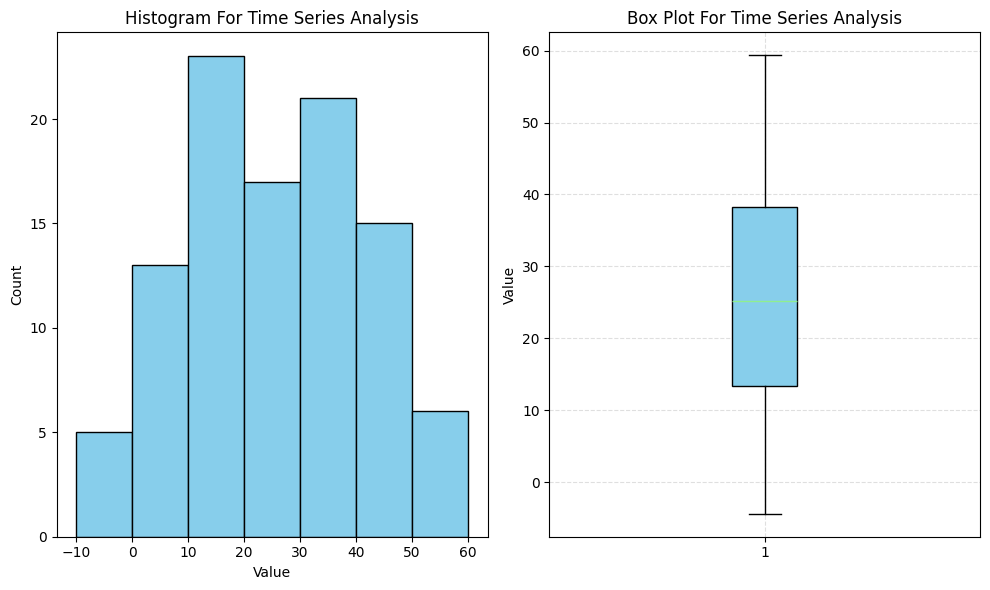

In [5]:
fig,ax=plt.subplots(1,2, figsize=(10,6))

bins = 7
hist_range = (-10,60)
ax[0].hist(sample_ts_df['Value'], bins=bins, range=hist_range, edgecolor='black')
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Count")
ax[0].set_title("Histogram For Time Series Analysis")

ax[1].boxplot(sample_ts_df['Value'], patch_artist=True)
ax[1].set_title("Box Plot For Time Series Analysis")
ax[1].set_ylabel("Value")
ax[1].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation: </span></h3> 1. The histogram shows us which number appears the most often. It also shows if there are groups of numbers close together (aka presence of clusters). In our case, most of the numbers are between 10 and 20.<br> 2. The box plot shows us if there are any outliers in the data. In our case there is none.

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;2. Time Series Plot </span></h2> By checking time series plot we can get basic understanding of <b>trends</b> (<i>general direction of the timeseries</i>), <b>patterns</b> (<i>regular ups and downs</i>), anything <b>unusual</b> (<i>noise</i>) etc.

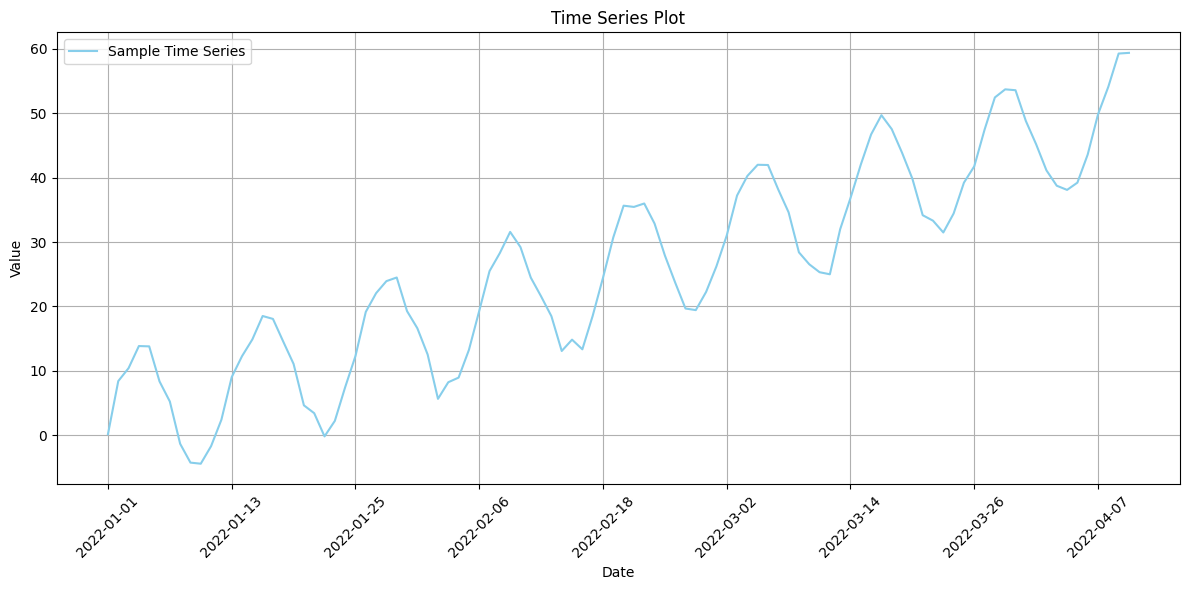

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(sample_ts_df.index, sample_ts_df['Value'], label='Sample Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.grid(True)
plt.xticks(sample_ts_df.index[::12], rotation=45) # Adjusted this multiple times to find correct seasonality window
plt.tight_layout()
plt.show()

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation: </span></h3> We can observe some trend (going upwards), pattern (sinewaves in every 12 days -<i>seasonality</i>) and some random pattern (noise) in this data, lets try to decompose the timeseries to understand it better.

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;3. Decomposition: </span></h2> We can decompose a time series into its <b>trend</b>, <b>seasonal</b>, and <b>residual components</b> using techniques like <i><span style="color:brown;">additive</span></i>, <i><span style="color:brown;">multiplicative</span></i>, or <i><span style="color:brown;">STL </span></i>decomposition.<br><h3>Which Decomposition method to choose?</h3>
<ul>
    <li>Additive decomposition: When the seasonal fluctuations remain relatively constant across different levels of the time series,</li> 
    <li>Multiplicative decomposition: When the seasonal fluctuations increase or decrease in proportion to the overall level of the time series.</li>
    <li>STL: When the seasonal patterns in the time series data are complex or non-linear, or when there are irregularities that traditional additive or multiplicative decomposition methods may not capture effectively.</li>
</ul>

As <span style="color:red;"><b> STL </b></span> is a robust decomposition method which can handle various types of time series data, we will use it for our time series. <br><br><b>Remember:</b><br>
    1. Both Additive and Multiplicative Decomposition uses same "seasonal_decompose" method <span style="color:skyblue;">("from statsmodels.tsa.seasonal import seasonal_decompose")</span>. "model" parameter in "seasonal_decompose" method distinguishes which method <span style="color:skyblue;">("additive or multiplicative")</span> to use. <br>
    2. We cannot use Multiplicative Decomposition for zero and negative values. <br>
    3. STL Decomposition method expects a series like object. That is why we either need to convert our dataframe into a series or mention only one column.<br>
    4. The "seasonal" parameter value in STL is very important so we have to choose it carefully. The value must be odd and larger than season. If we are not sure about the number, we can start with the default value (7) and experiment with slightly higher odd values (e.g., 9, 11, 13..). A higher season value captures smoother seasonal patterns but might miss out on finer details and a lower season value might capture more details but could also introduce noise into the seasonal component.
It's often recommended to keep season less than half the length of our data to avoid overfitting the seasonal component.<br><br>

In [7]:
#Let's turn this into a function since we'll use it again
def plot_timeseries_decompositon(df):
    result_stl = STL(df, seasonal=13).fit() # as we saw a 12days seasonal pattern in our data
    stl_trend = result_stl.trend
    stl_seasonal = result_stl.seasonal
    stl_residual = result_stl.resid

    fig, axs = plt.subplots(4, 1, figsize=(12,8), sharex=True)

    axs[0].plot(df, label='Original')
    axs[0].set_title('Original Time Series')
    axs[0].legend(loc='upper left')

    axs[1].plot(stl_trend, color='green', label='Trend')
    axs[1].set_title('Trend Component')
    axs[1].legend(loc='upper left')

    axs[2].plot(stl_seasonal, color='red', label='Seasonal')
    axs[2].set_title('Seasonal Component')
    axs[2].legend(loc='upper left')

    axs[3].plot(stl_residual, color='purple', label='Noise')
    axs[3].set_title('Residuals Component')
    axs[3].legend(loc='upper left')
    
    plt.show()

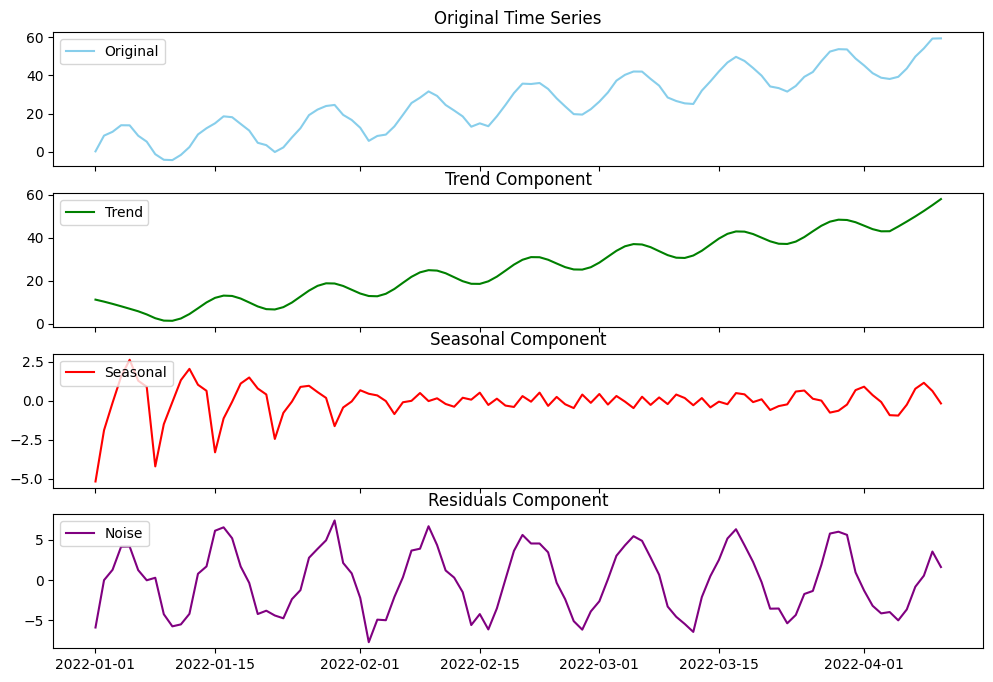

In [8]:
plot_timeseries_decompositon(sample_ts_df['Value'])

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation: </span></h3><br> 1. <b>Seasonal Changes:</b> We can see intially seasonal component was large, reduced over time and then started increasing again, it indicates a more complex seasonal pattern that evolves over time.<br>2. <b>Forecasting</b>(<i>Making Prediction</i>)<b>:</b> To predict what will happen next, we'll make our time series stationary. For that, we'll take out the trend, seasonal changes, and any leftover errors one by one to see how the remaining data behaves. Then, we'll try to predict future values and see how well it works. But remember, we'll only make models using data that stays consistent over time (stationary time series) without losing much details.<br>3. <b>Understanding Stationarity of the Data:</b> Now that we know about the different parts of our data (trend, seasonality, etc.), let's look at more details about it, like how consistent it is over time (stationarity).<br>

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;4. Rolling Statistics: </span></h2><br>
1. We will use the <span style="color:red;">rolling()</span> function on the time series data to calculate the rolling mean and rolling standard deviation over a window of size window_size.<br>
2. We then plot the original time series data along with the rolling mean and rolling standard deviation for visualization.<br>
3. The time series is stationary if the mean and standard deviation remain constant with time (with the naked eye look to see if the lines are straight and parallel to the x-axis).<br>
4. For this process selecting correct window size is very important. Larger window sizes result in smoother rolling statistics but may obscure short-term patterns. We might need to experiment with different window sizes to find the one that best suits our analysis requirements. Here are some tips for choosing a window size👇<br><span style="color:gray;">
    &nbsp;&nbsp;&nbsp;<b><span style="color:brown;">a) Not sure about the data? Start small!</span></b> A small window keeps the lines detailed and avoids missing important bits. We can then slowly increase the window size and see how it affects the lines. This avoids oversmoothing the data and potentially missing important details. <br>
&nbsp;&nbsp;&nbsp;<b><span style="color:brown;">b) When we know the frequency of our timeseries: </span></b> These are some good starting window sizes we can try for different frequency data, Daily data: 5, 10, or 20 days. Weekly data: 2, 4, or 8 weeks. Monthly data: 3, 6, or 12 months.
<br>
&nbsp;&nbsp;&nbsp;<b><span style="color:brown;">c) Elbow method: </span></b> We can use "elbow method" to identify an "optimal" window size by looking for the point where the variability in the lines is lowest.<br><br></span>

✅ We will turn all our plotting code into a function. This way, we can easily use the same code again to make the same graphs after our time series becomes stable (stationary).<br>

In [9]:
def plot_rolling_statistics(df,y_axis_label):
    rolling_mean = df.rolling(window=7).mean() #for this sample data i chose window=9
    rolling_std = df.rolling(window=7).std()

    plt.figure(figsize=(10, 6))
    plt.plot(df, label='Time Series')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.title('Time Series Data with Rolling Statistics')
    plt.xlabel('Date')
    plt.ylabel(y_axis_label)
    plt.legend()
    plt.grid(True)
    plt.show()

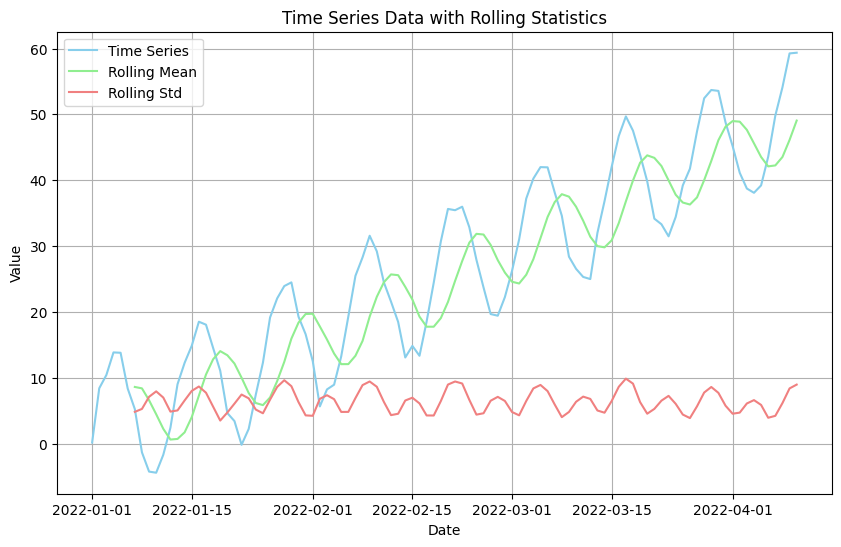

In [10]:
plot_rolling_statistics(sample_ts_df['Value'],'Value')

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation: </span></h3> We can see the data is not staionary but to be sure, let's use a statistical test called ADF to confirm our guess.<br>

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;5. ADF: </span></h2>
ADF stands for Augmented Dickey-Fuller test. It's a statistical test commonly used in time series analysis to determine whether a given time series is stationary. The ADF test specifically checks for the presence of a unit root in the data. A unit root is a characteristic of some time series that can cause problems in statistical inference, including making forecasts unreliable.

👇<u>Here's a breakdown of the key points about the ADF test</u>:

<b>1. Purpose:</b> Tests for the presence of a unit root in a time series to assess stationarity.<br>
<b>2. Null Hypothesis (H0):</b> The series has a unit root (non-stationary).<br>
<b>3. Alternative Hypothesis (HA):</b> The series is stationary (no unit root).<br>
<b>4. Output:</b> The ADF test produces statistic, p-value, critical values etc.<br>

✅<b>Interpretation:</b>


1. ADF statistic value measures how strong the evidence is against stationarity (negative values favor stationarity). If the ADF statistic is more negative than the absolute value of the critical value at any of the significance levels (1%, 5%, or 10%), then we can reject the null hypothesis (non-stationarity) and conclude that the time series is likely stationary. While a lower ADF statistic (more negative) strengthens the evidence for stationarity, it's crucial to compare it to the critical values at the chosen significance level for a definitive conclusion.
2. The p-value obtained from the ADF test indicates the probability of observing the test statistic (ADF statistic) given that the null hypothesis is true. In the <i>statsmodels.tsa.stattools.adfuller</i> function in Python, the significance level is already set to 0.05. So if the p value is less than 0.05 we can reject the null hypothesis and conclude that the time series is stationary and if it is above 0.05 then we can consider the time series as non stationary.

<span style="color:brown;">Note:</span> If a time series is stationary and has a particular behaviour over a given time interval, then it is safe to assume that it will have same behaviour at some later point in time. This test is very important as most statistical modelling methods assume or require the time series to be stationary.

In [11]:
def timeseries_stationary_check_using_ADF(df):
    result = adfuller(df)

    adf_statistic = result[0]
    p_value = result[1]

    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    print(f'The number of lags used: {result[2]}')
    print('The number of observations used for the ADF regression and calculation of the critical values:',
          result[3])
    print('Critical Values:')  
    for key, value in result[4].items():  
        print('\t{}: {}'.format(key, value)) 

In [12]:
timeseries_stationary_check_using_ADF(sample_ts_df['Value']) 

ADF Statistic: 1.0547321741753042
p-value: 0.9948111464183
The number of lags used: 12
The number of observations used for the ADF regression and calculation of the critical values: 87
Critical Values:
	1%: -3.5078527246648834
	5%: -2.895382030636155
	10%: -2.584823877658872


<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation: </span></h3> As per both ADF statistics and p value the time series is non stationary. Let's try to make this time series a stationary one.<br>

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;6. Make The Time Series Staionary </span></h2> 

⏳ There are different ways to make a time series data stationary. Here are some methods ⬇️,

1. <b> Subtracting Average:</b> This is the easiest way. We calculate the average value for a certain period (like a rolling average) and subtract it from each data point. This removes any overall up or down trend.<br>

2. <b>Exponential Smoothing:</b> This is another way to remove trends. It considers past data points, but gives more weight to recent ones. <br>

3. <b>Differencing:</b> This is a common method where we subtract the previous value from each data point. Be careful though, it can increase the variance and lose some information at the beginning of the series.<br>

4. <b>Transformations:</b> These can stabilize the variance and make the data more normally distributed, which is often desirable for time series analysis techniques.<ul>
<li>Logarithm (Log): Helpful for data which has a strong upward(exponential) trend.</li>
<li>Square Root: Useful for data with squared patterns.</li>
<li>Box-Cox: This is a more general approach for various data patterns.</li>
</ul>

5. <b>Linear Detrending:</b> This removes the long-term trend completely by fitting a straight line to the data and subtracts it.<br>

6. <b>Seasonal Adjustment:</b> We can remove seasonal effects by subtracting the same seasonal lag (e.g., previous month's or previous week's value) from each data point.<br><br>

✅ <b><span style="color:red;">How to Choose the Right Technique?</span></b> We need to try different techniques and compare the results. We should choose the one method which gives a stationary series with minimal information loss.

💹 We will start with "Differencing" method to detrend our timeseries. if it does not work we will try some other method to make our time series stationary. Let's try it.

In [13]:
sample_ts_df['Detrended'] = sample_ts_df['Value']-sample_ts_df['Value'].shift(1)

In [14]:
sample_ts_df['Detrended'].isnull().sum() # null values will cause problem calculating ADF so check and remove those

1

In [15]:
sample_ts_df.dropna(inplace=True)

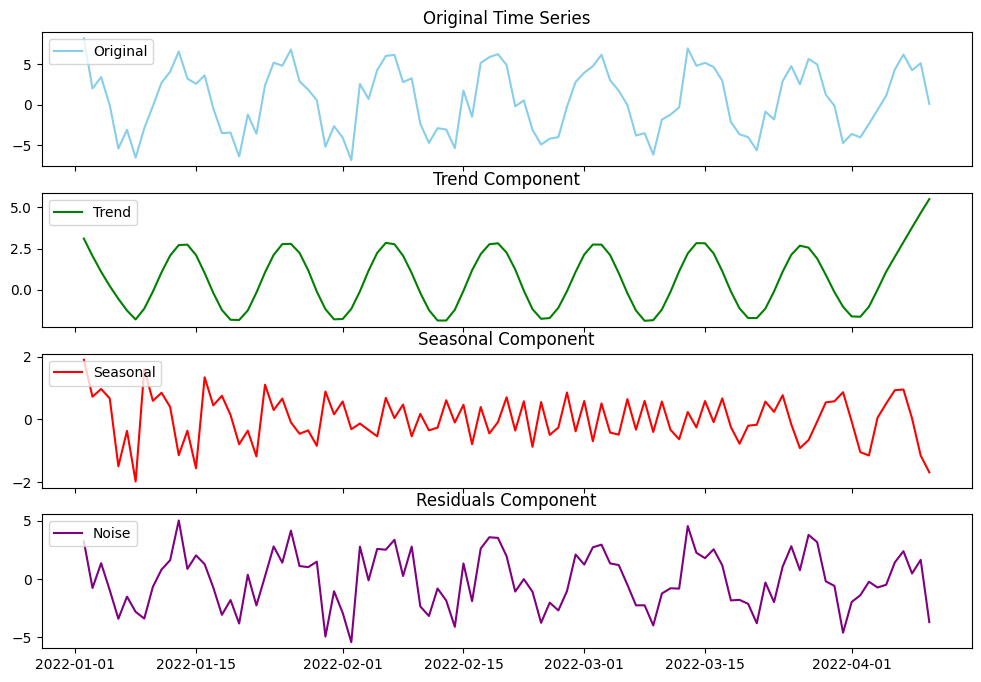

In [16]:
plot_timeseries_decompositon(sample_ts_df['Detrended'])

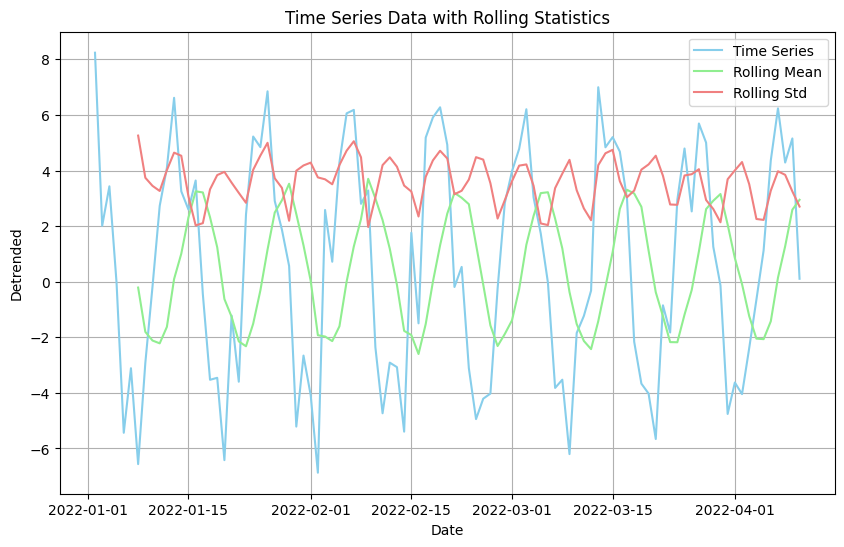

In [17]:
plot_rolling_statistics(sample_ts_df['Detrended'],'Detrended')

In [18]:
timeseries_stationary_check_using_ADF(sample_ts_df['Detrended']) 

ADF Statistic: -7.448056087667547
p-value: 5.767779110843784e-11
The number of lags used: 12
The number of observations used for the ADF regression and calculation of the critical values: 86
Critical Values:
	1%: -3.5087828609430614
	5%: -2.895783561573195
	10%: -2.5850381719848565


<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation: </span></h3> We can see our data is now stationary so we can apply time series models like ARMA/ARIMA. But before applying lets check how it will perform if we remove seasonality and residuals.<br>

🦋 <i>We'll be making multiple changes in our time series which might require dropping multiple rows from it, but it is already stationary, so let's be safe and copy the original data to a new dataframe first.</i>

In [19]:
original_ts_df=sample_ts_df.copy()
original_ts_df.head(3)

,Value,Detrended
Date,,
2022-01-02,8.417029,8.238175
2022-01-03,10.428937,2.011908
2022-01-04,13.859624,3.430687


In [20]:
weekly_means = sample_ts_df.groupby(sample_ts_df.index.week).mean()
sample_ts_df['Deseasonalized'] = sample_ts_df['Detrended'] - weekly_means.loc[sample_ts_df.index.week]\
['Detrended'].values
sample_ts_df.dropna(inplace=True)
sample_ts_df.shape[0]

99

In [21]:
sample_ts_df['Smoothed']=sample_ts_df['Deseasonalized'].rolling(window=7).mean()
sample_ts_df.dropna(inplace=True)
sample_ts_df.shape[0]

93

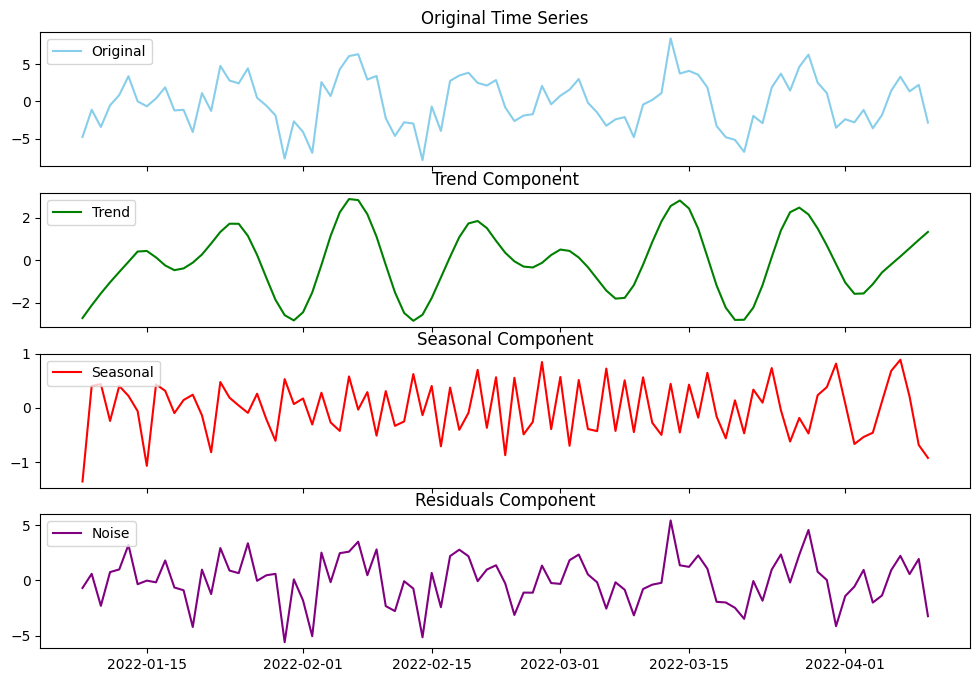

In [22]:
plot_timeseries_decompositon(sample_ts_df['Deseasonalized'])

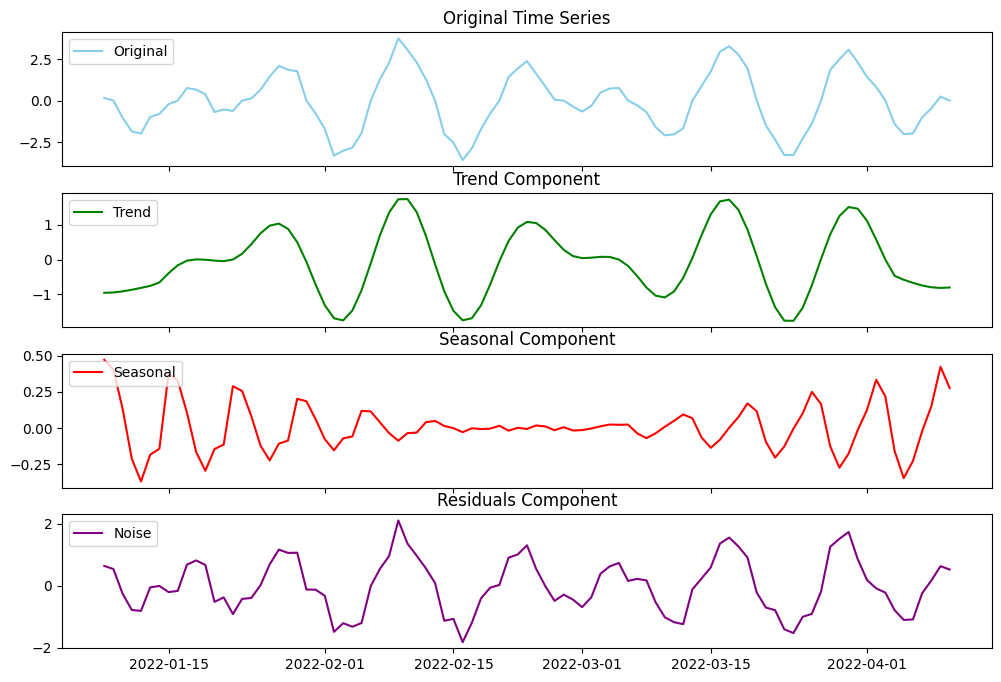

In [23]:
plot_timeseries_decompositon(sample_ts_df['Smoothed'])

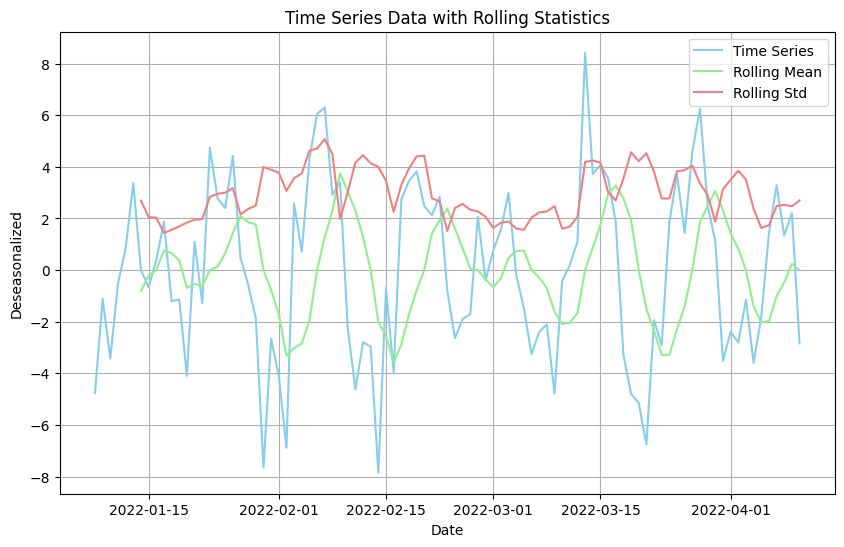

In [24]:
plot_rolling_statistics(sample_ts_df['Deseasonalized'],'Deseasonalized')

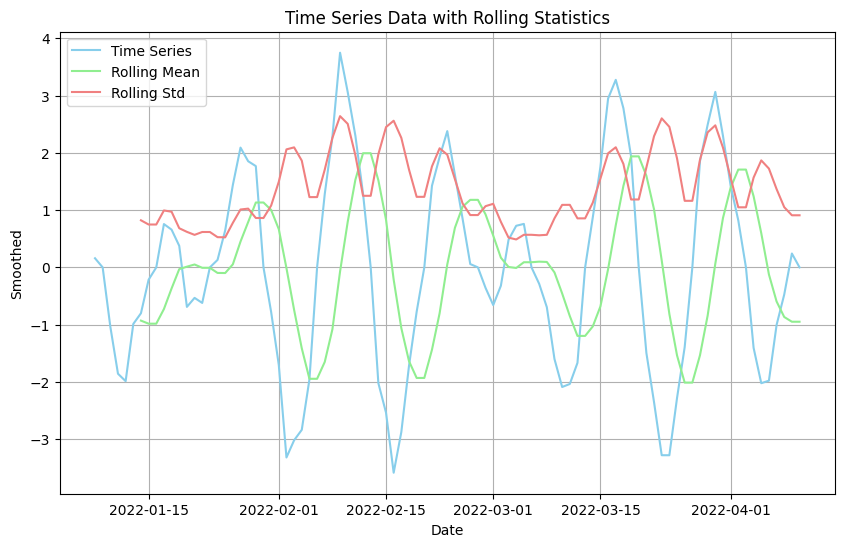

In [25]:
plot_rolling_statistics(sample_ts_df['Smoothed'],'Smoothed')

In [26]:
timeseries_stationary_check_using_ADF(sample_ts_df['Deseasonalized']) 

ADF Statistic: -5.172955526841462
p-value: 9.981447728831591e-06
The number of lags used: 12
The number of observations used for the ADF regression and calculation of the critical values: 80
Critical Values:
	1%: -3.5148692050781247
	5%: -2.8984085156250003
	10%: -2.58643890625


In [27]:
timeseries_stationary_check_using_ADF(sample_ts_df['Smoothed']) 

ADF Statistic: -8.183450013000211
p-value: 8.01594550210369e-13
The number of lags used: 12
The number of observations used for the ADF regression and calculation of the critical values: 80
Critical Values:
	1%: -3.5148692050781247
	5%: -2.8984085156250003
	10%: -2.58643890625


<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation: </span></h3> Removing seasonality  didn't improve our data much. It's still stationary, but taking out trends made it even more stable than removing just seasonal changes. This way, we lose less data. When we smoothed our data it became more stable but, for now, we'll just use the data without the trends (detrended) later we will try smoothed data as well.<br>

<span style="color:gray;"><b>Heads up!!</b> Our code removes the weekly seasonality, because we saw repeating patterns every 11 to 12 days. Removing weekly seasonality makes sense here. We can also try to remove 12 days seasonality and test how that performs. When we are not sure we can try removing patterns in different time windows and see which one works best.</span>


<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;6. ACF and PACF: </span></h2> There are two things we need to do before building our model: 1) Pick the right kind of model (AR, MA, ARMA, ARIMA) and 2) Figure out the right settings (orders: p,d and q) for that model. We already know value for d from stationarity check. ACF and PACF methods will help us choose the best model for our data and p,q value for those models. Some resources below to understand this process better👇.

💡 For basic understanding of AR, MA, ARMA and ARIMA model check below link ⬇️

https://towardsdatascience.com/time-series-models-d9266f8ac7b0

💡 Here are some resources to understand ACF, PACF concepts better ⬇️

In [28]:
from IPython.display import YouTubeVideo
YouTubeVideo("ZE_WGBe0_VU", width=400)

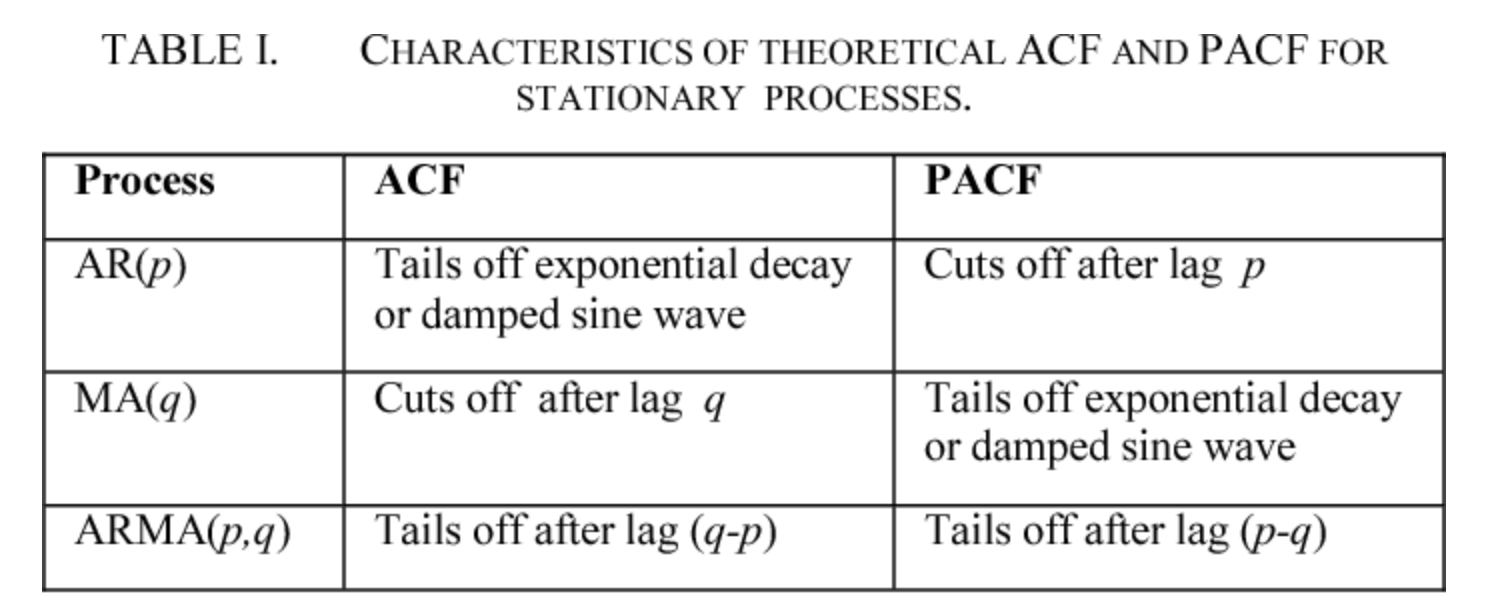

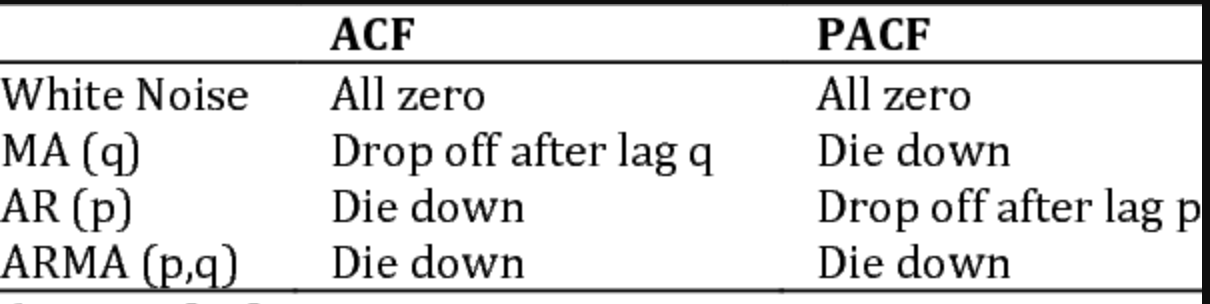

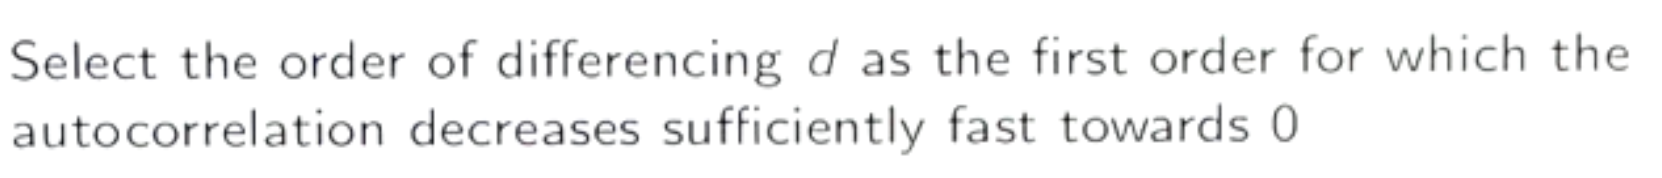

In [29]:
def plot_ACF_PACF(df,acf_lags,pacf_lags):
    plt.figure(figsize=(12, 6))
    plot_acf(df, lags=acf_lags, ax=plt.gca()) #maximum total values-1
    plt.title('Autocorrelation Function (ACF)')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

    plt.figure(figsize=(12, 6))
    plot_pacf(df, lags=pacf_lags, ax=plt.gca())
    plt.title('Partial Autocorrelation Function (PACF)') #maximum will be ACF/2
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.show()

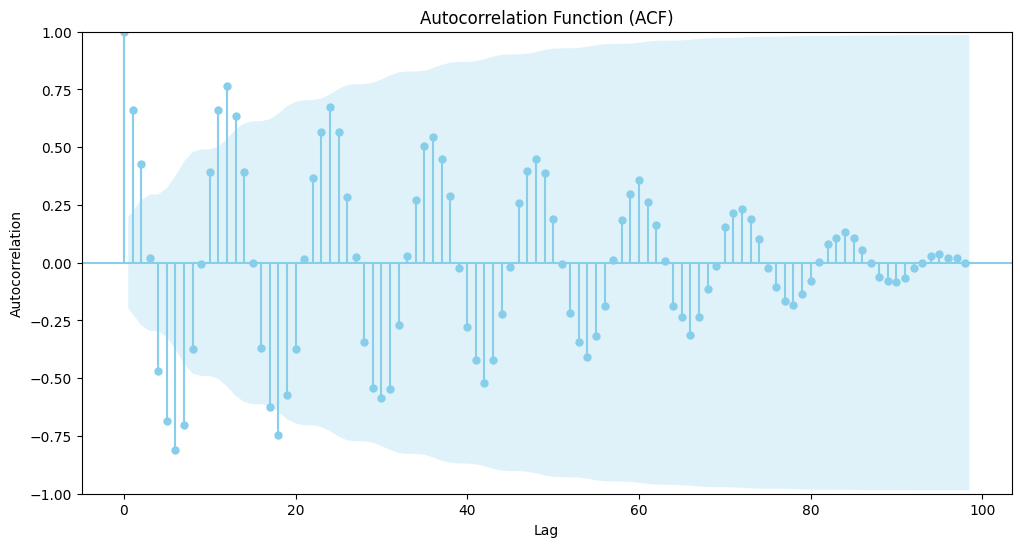

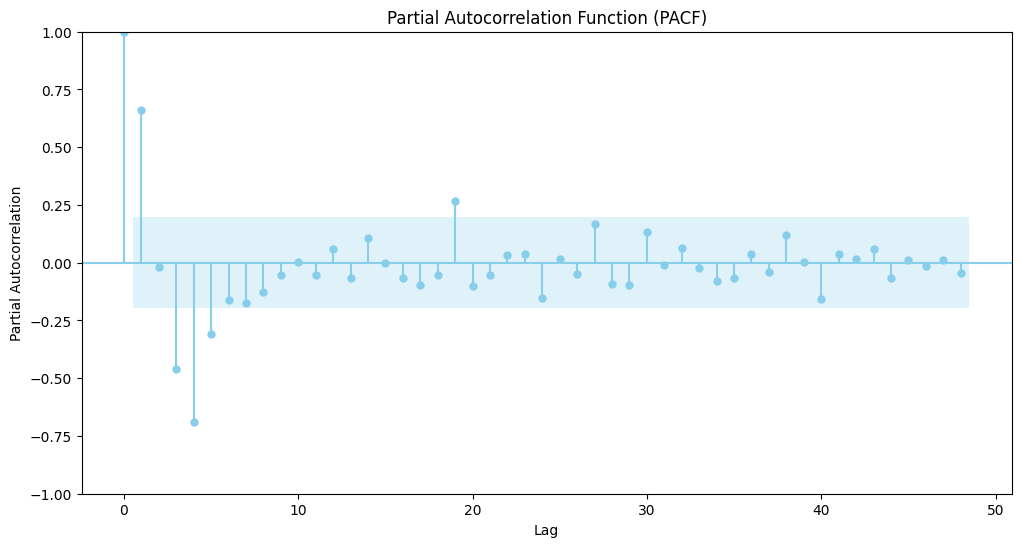

In [30]:
plot_ACF_PACF(original_ts_df['Detrended'],98,48)

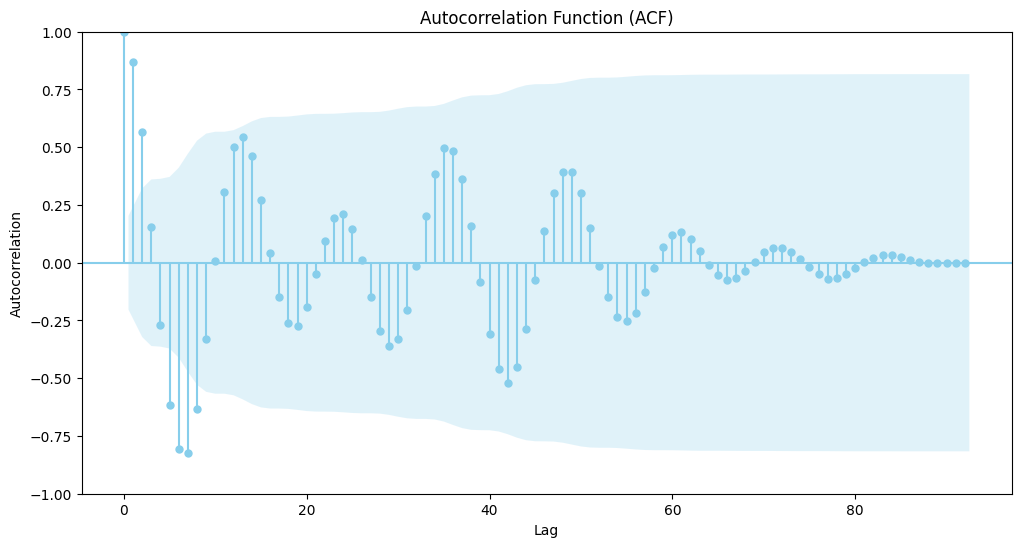

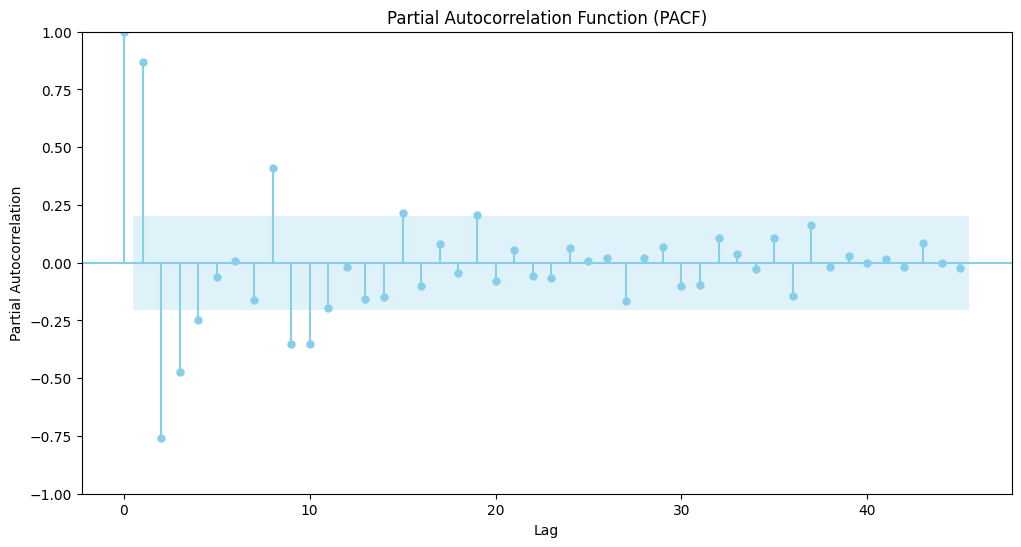

In [31]:
plot_ACF_PACF(sample_ts_df['Smoothed'],92,45)

<h3> <span style="color:pink;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Information: </span></h3><ol>
    <li><b>Autocorrelation at Lag 0:</b> This is like comparing a time series to itself. Because of that, it always results in a big jump at lag 0. This jump is normal and doesn't tell us anything interesting about the data's past and future. So, when counting spikes for future models, we can just skip this lag 0 jump.</li>
    <li><b>Decaying Pattern:</b> In the ACF and PACF charts, if the lines in neither graph slowly flatten out as we move to the right, it means our data is not stationary. In a stationary chart the effects of past values become less important over time (decaying pattern). But if our data isn't stationary then we'll need to make it stationary before finding p and q.</li>
    <li><b>Significant Spikes:</b> Spikes at specific lags (excluding lag 0) might indicate dependence on past values at those lags. Further we can use statistical tests to assess the significance of these spikes.</li>
</ol>

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation: </span></h3> As we can see in the graph here are some possible values we can try for p and q,
<ul>
    <li>If we use only detrended data then,
        <ul>
            <li>maximum:  p=5 and q=10 </li>
        </ul>
    <li>If we use seasonality + smoothed data then,
        <ul>
            <li>maximum:  p=8 and q=6 </li>
        </ul>
</ul>


<h1> <span style="color:red;"> Step 2:- Build The Model</span></h1>

<b> Which Model to Choose?</b> We can use ARMA on the 'Detrended' component of the original time series data (original_ts_df['Detrended']), or we can use ARIMA on the original time series data (original_ts_df['Value']) with d=1 for differencing, or alternatively, we can apply ARIMA on the 'Detrended' component of the original data (original_ts_df['Detrended']) with d=0 for no differencing. 

✅ Since ARIMA with d=0 is basically an ARMA model, we will try different hyper-parameter settings for p and q. We'll use the values we saw earlier in the ACF and PACF charts.

✅ For hyper parameter tuning we will use Optuna python library.

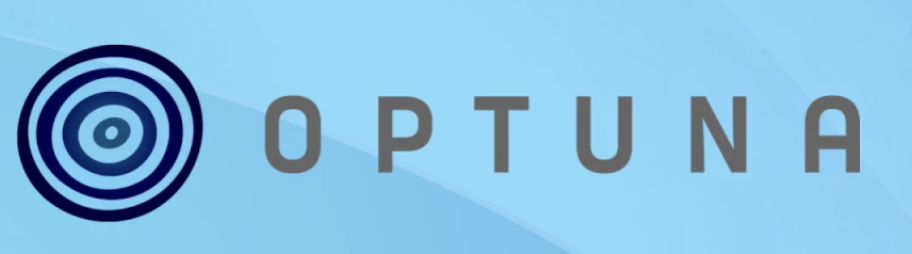

💡 Before we use Optuna for HPO let's try to understand some important concepts about Optuna.<br>

<b>1. Why are we using Optuna?</b> Optuna uses an efficient algorithm based on Bayesian optimization to search the hyperparameter space, which can often find better hyperparameter configurations in fewer iterations compared to grid search or random search.<br>
<b>2. How Optuna Works internally?</b> Optuna uses two strategies for this: <u>sampling strategy and pruning strategy</u>. In the sampling strategy, it decides the next configuration using previous search history. This strategy uses multiple methods to achieve this. First, it uses Global Search with TPE (Tree-structured Parzen Estimator) and then local search with CMA-ES.  The pruning strategy works by looking at intermediate learning curves to detect and stop underperforming trials in the middle of training. In short, by applying these two strategies, Optuna efficiently explores the search space, focusing on regions likely to contain better-performing configurations while pruning out those that underperform.<br>
<b>3. Key Concepts in Optuna:</b>
<ul>
<li><b>Objective Function:</b> The objective function in Optuna is a Python function that takes a single argument, the trial object. The trial object is used to sample hyperparameters from predefined distributions and track the results of each trial. Within the objective function, hyperparameters are sampled from the trial object, a machine learning model is trained with these hyperparameters, and its performance is evaluated on a validation set. The objective function then returns a scalar value representing the performance of the model, such as accuracy, loss, or any other relevant metric.</li>
<li><b>Study:</b> A study is a container that manages the optimization process in Optuna. It keeps track of completed trials, maintains the search history, and provides methods for retrieving information about the optimization process.</li>
<li><b>Trial:</b> A trial represents a single evaluation of the objective function with a specific set of hyperparameters. Optuna generates new trials based on its search strategy and updates the study with the results of each trial.</li>
</ul><br>

[Click Here For More Information](https://github.com/optuna/optuna)

Hyper parameter Tuning

In [32]:
def optuna_objective(trial):
    global train_data,validation_data
    
    #Based on ACF and PACF analysis
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 0)
    q = trial.suggest_int('q', 0, 10)
    trend = trial.suggest_categorical('trend', ['n', 'c', 't', 'ct'])
    
    model = ARIMA(endog=train_data, order=(p, d, q), trend=trend)
    fitted_model = model.fit()

    predictions = fitted_model.predict(start=len(train_data), end=len(train_data) + len(validation_data) - 1)

    mse = mean_squared_error(validation_data, predictions)
    
    return mse

Training (Training+Validation) and Testing Data

In [33]:
train_index = int(0.65 * len(original_ts_df))
validation_index = train_index + int(0.15 * len(original_ts_df))
train_data = original_ts_df['Detrended'][:train_index]
validation_data = original_ts_df['Detrended'][train_index:validation_index]
test_data = original_ts_df['Detrended'][validation_index:]

In [34]:
study = optuna.create_study(direction='minimize')
study.optimize(optuna_objective, n_trials=20)

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_score)

[I 2024-03-17 23:05:19,817] A new study created in memory with name: no-name-080543f4-b1e6-4cae-b559-ed457fc61079
[I 2024-03-17 23:05:19,987] Trial 0 finished with value: 1.5016993417070743 and parameters: {'p': 4, 'd': 0, 'q': 3, 'trend': 'ct'}. Best is trial 0 with value: 1.5016993417070743.
[I 2024-03-17 23:05:20,277] Trial 1 finished with value: 2.5179754705701862 and parameters: {'p': 4, 'd': 0, 'q': 6, 'trend': 'n'}. Best is trial 0 with value: 1.5016993417070743.
[I 2024-03-17 23:05:20,806] Trial 2 finished with value: 4.076764504525907 and parameters: {'p': 2, 'd': 0, 'q': 7, 'trend': 't'}. Best is trial 0 with value: 1.5016993417070743.
[I 2024-03-17 23:05:21,365] Trial 3 finished with value: 1.2899997683862972 and parameters: {'p': 4, 'd': 0, 'q': 9, 'trend': 'ct'}. Best is trial 3 with value: 1.2899997683862972.
[I 2024-03-17 23:05:21,445] Trial 4 finished with value: 13.885514515713464 and parameters: {'p': 3, 'd': 0, 'q': 0, 'trend': 'ct'}. Best is trial 3 with value: 1.28

Best Hyperparameters: {'p': 4, 'd': 0, 'q': 8, 'trend': 'ct'}
Best Mean Squared Error: 1.1825928802467371


In [35]:
p,d,q,trend_val=best_params['p'],best_params['d'],best_params['q'],best_params['trend']

Build and fit our model using best parameters

In [36]:
train_dalidation_data=pd.concat([train_data,validation_data])
model = ARIMA(train_dalidation_data, order=(p, d, q), trend=trend_val)
fitted_model = model.fit()

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Detrended   No. Observations:                   78
Model:                 ARIMA(4, 0, 8)   Log Likelihood                -118.260
Date:                Sun, 17 Mar 2024   AIC                            266.520
Time:                        23:05:25   BIC                            301.871
Sample:                    01-02-2022   HQIC                           280.672
                         - 03-20-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4717      0.033     14.149      0.000       0.406       0.537
x1             0.0005      0.001      0.548      0.584      -0.001       0.002
ar.L1         -0.0134      0.190     -0.071      0.944      -0.386       0.359
ar.L2          1.1087      0.176      6.303      0.000       0.764       1.454
ar.L3         -0.1714      0.181     -0.946      0.344      -0.527       0.184
ar.L4         -0.9033      0.193     -4.690      0.000      -1.281      -0.526
ma.L1         -0.7545      1.021     -0.739      0.460      -2.755       1.246
ma.L2         -1.1411      1.174     -0.972      0.331      -3.442       1.160
ma.L3          1.0269      0.518      1.983      0.047       0.012       2.042
ma.L4          0.0867      1.102      0.079      0.937      -2.073       2.247
ma.L5         -0.4431      0.984     -0.450      0.652      -2.372       1.485
ma.L6          0.6549      0.585      1.120      0.263      -0.491       1.801
ma.L7         -0.2330      0.340     -0.686      0.493      -0.899       0.433
ma.L8         -0.1775      0.250     -0.711      0.477      -0.667       0.312
sigma2         1.1487      0.689      1.668      0.095      -0.201       2.499
===================================================================================
Ljung-Box (L1) (Q):                   1.87   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.17   Prob(JB):                         0.95
Heteroskedasticity (H):               0.54   Skew:                             0.03
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation: </span></h3>

The summary shows:

1. No seasonal or outside influences (exogenous components) are affecting our data.
2. From z statistics we can see only AR 2 and AR 4 has significant impact on the model, There is no evidence that  MA 8, MA9 coefficient has any impact on our model.
3. There's no leftover dependence (autocorrelation) in the errors (residuals).
4. The errors are spread out normally.
5. The spread of the errors is constant.
6. The p value of having exogenous component is 0.584. So we can say, there is no seasonal and exogenous component present in the distribution.
7. The data leans a little to the left (skewness) and has slightly fatter tails (kurtosis) than a normal distribution. <<i>skewness is negative means the distribution is skewed to the left and Positive kurtosis (greater than 3) indicates that the distribution has heavier tails and a sharper peak compared to a normal distribution</i>>

In [37]:
model = ARIMA(train_dalidation_data, order=(4, 0, 7), trend=trend_val)
fitted_model = model.fit()

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Detrended   No. Observations:                   78
Model:                 ARIMA(4, 0, 7)   Log Likelihood                -120.692
Date:                Sun, 17 Mar 2024   AIC                            269.385
Time:                        23:05:25   BIC                            302.379
Sample:                    01-02-2022   HQIC                           282.593
                         - 03-20-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4738      0.037     12.707      0.000       0.401       0.547
x1             0.0004      0.001      0.369      0.712      -0.002       0.002
ar.L1          0.1397      0.164      0.850      0.395      -0.182       0.462
ar.L2          0.9573      0.181      5.279      0.000       0.602       1.313
ar.L3         -0.2195      0.188     -1.168      0.243      -0.588       0.149
ar.L4         -0.7824      0.166     -4.720      0.000      -1.107      -0.458
ma.L1         -0.8136      0.319     -2.551      0.011      -1.439      -0.189
ma.L2         -0.7713      0.434     -1.775      0.076      -1.623       0.080
ma.L3          0.7787      0.351      2.222      0.026       0.092       1.466
ma.L4         -0.2496      0.328     -0.762      0.446      -0.892       0.392
ma.L5         -0.1150      0.343     -0.335      0.738      -0.788       0.558
ma.L6          0.6723      0.295      2.281      0.023       0.095       1.250
ma.L7         -0.4133      0.207     -1.992      0.046      -0.820      -0.007
sigma2         1.1625      0.357      3.259      0.001       0.463       1.862
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.47   Prob(JB):                         0.73
Heteroskedasticity (H):               0.63   Skew:                             0.16
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation: </span></h3>

Looking at the AIC, BIC, and HQIC scores, it seems like the model's performance actually got worse. So, we can't trust this summary alone. Instead, we'll go back to the model we had before.

In [38]:
model = ARIMA(train_dalidation_data, order=(p, d, q), trend=trend_val)
fitted_model = model.fit()

Visualization of our model:

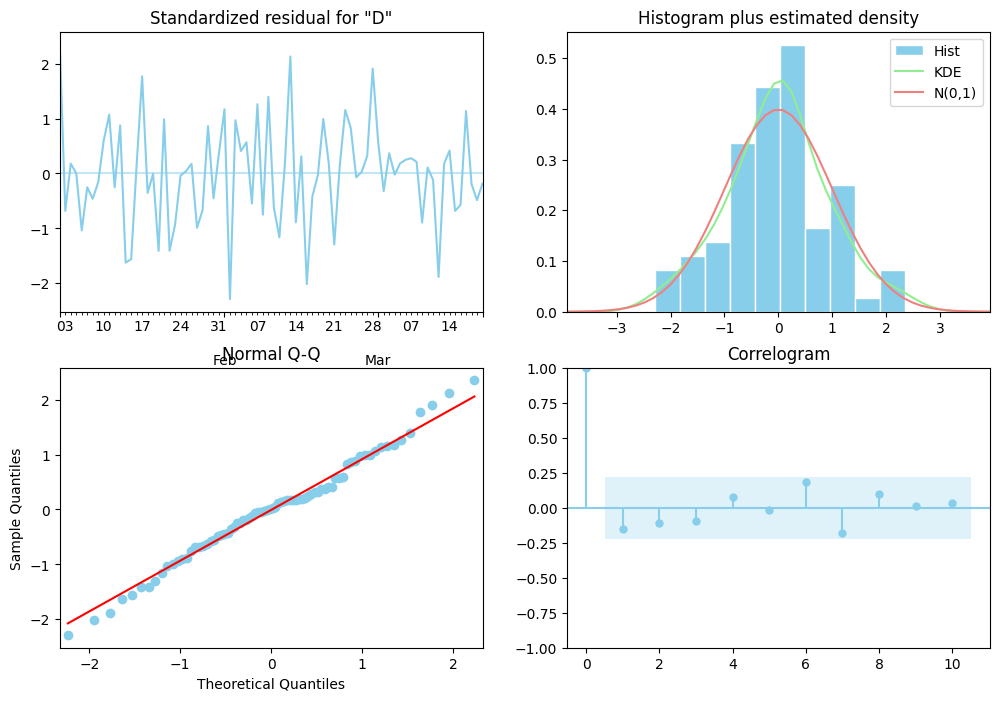

In [39]:
fitted_model.plot_diagnostics(figsize=(12,8))
plt.show()

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation: </span></h3>

<ol>
<li><b>Standardized residual</b>: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.</li>
<li><b>Histogram</b>: The density plot suggest normal distribution.</li>
<li><b>Theoretical Quantiles</b>: The graph suggests the data is normally distributed, but some asymmetry present on both the tails.</li>
<li><b>Correlogram</b>: This correlogram helps us assess whether the residuals exhibit any significant autocorrelation at different lags. If any of the autocorrelation values exceed shaded region, it suggests that the residuals are significantly correlated at that lag. In our case all the residuals are uncorrelated. If there had correlation at some lags then That would mean our model might have missed some patterns in the data.<ul>
    In that case what can we do?
    <li>Try a different model like SARIMA.</li>
    <li>Transform the data (like taking the log).</li>
    <li>Try to get more information and add extra variables to the model.</li></ul></li>
</ol>

✅ Overall, the model seems pretty good for now. Let's use it for forecasting, and then we can try to improve it later.

Predictions:

In [40]:
predictions = fitted_model.forecast(steps=len(test_data))

plot_predict(fitted_model) #for some reason it is returning same plot twice, will check it later
#currently we will disable this code but if we run we can see our entire forecast is in 95% confidence level

<b>Evaluation Metric Of a model:</b> RMSE, MAE or MAPE.

In [41]:
rmse = np.sqrt(mean_squared_error(test_data, predictions))
mae = mean_absolute_error(test_data, predictions)
mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)

Root Mean Squared Error: 1.1566187286163911
Mean Absolute Error: 0.9423861807172177
Mean Absolute Percentage Error: 155.6871800972691


<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation: </span></h3>

1. **Root Mean Squared Error (RMSE)**: The RMSE value of 1.15 indicates the square root of the average squared differences between the predicted values and the actual values. Lower RMSE values suggest better accuracy. In this case, an RMSE of 1.15 indicates moderate prediction error.

2. **Mean Absolute Error (MAE)**: The MAE value of .94 represents the average of the absolute differences between the predicted values and the actual values. MAE is less sensitive to outliers compared to RMSE. An MAE of .94 suggests that, on average, the predictions are off by approximately .94 units from the actual values.

3. **Mean Absolute Percentage Error (MAPE)**: For MAPE, lower values are generally preferred, as they indicate a smaller percentage difference between the predicted values and the actual values. A lower MAPE signifies better accuracy and closer alignment between the predicted and actual values. In our case MAPE is 155.69 which indicates that, on average, the predictions are off by approximately 155.69% relative to the actual values. This value is very high but we have to remember MAE and RMSE performance was good and MAPE is influenced by the magnitude of the actual values, if the actual values are small, even a small absolute difference can result in a large percentage error, leading to a high MAPE.

Overall, these evaluation metrics provide insights into the accuracy and performance of the forecasting model. While the RMSE and MAE values suggest moderate prediction errors, the relatively high MAPE value indicates that the predictions have a significant percentage difference from the actual values. Further analysis and refinement of the forecasting model may be necessary to improve its performance. The graph below might help us improve the model.

<h1> <span style="color:red;"> Step 3:- Prediction Visualization</span></h1>

💹〽️ This graph shows how well our model's predictions match the actual data. If the lines are close together, that means our model is doing a good job. If there are big differences, there's room to improve. By figuring out these differences, we can make our model better at predicting things in the future.

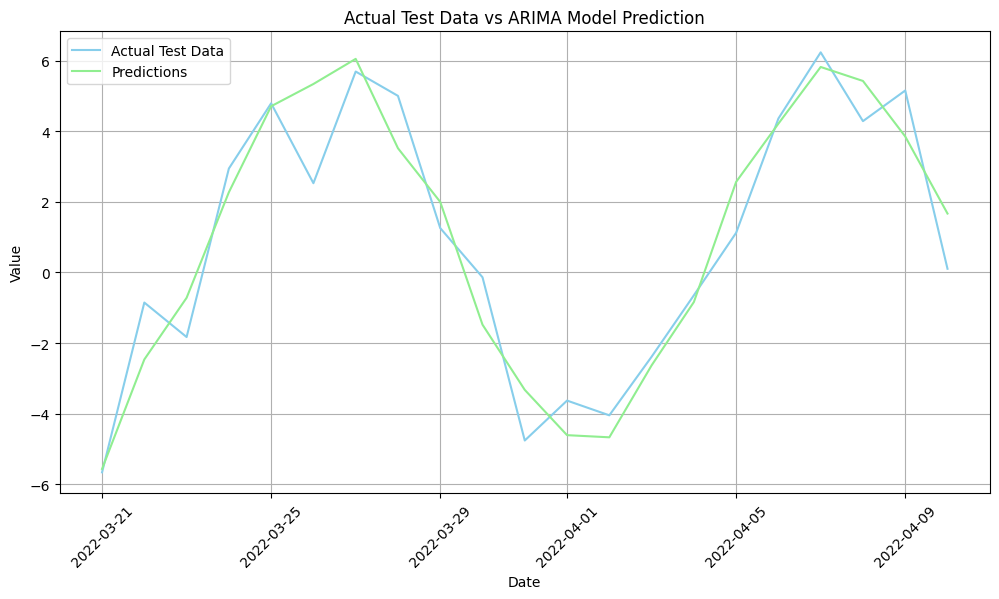

In [42]:
# Plot actual test data vs predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(test_data.index, predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Test Data vs ARIMA Model Prediction')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Conclusion: </span></h3>

Our model caught the longterm trend and pattern but unfortunately missed short term trend. To fix this, we can try different ways to remove the trend (like we did with the smoothed column) or use completely different models (like ensemble or stacking models). We'll try these things later to make it even better.